# Automatic Analysis of XAS *In-Situ* Data w.o. Measured Standards
Notebook showing an example workflow used for automatic analysis of XAS *in-situ* data when standards for both unreduced precursors and reduced metal foils have not been measured.

This notebook should only be considered as a help and guide for performing automatic analysis of XAS data. 
It is therefore encouraged to make modifications to the notebook to fit your specific needs.

# Imports
Here the required packages and functions are imported.

In [1]:
# Functions written for the analysis of XAS data
from autoXAS.data import *
from autoXAS.LCA import *
from autoXAS.plotting import *

%matplotlib inline

# Boolean flags
Here the values of boolean flags (True/False) that occur throughout the notebook can be changed.

In [2]:
# Decide if transmission or absorption data should be used for normalization and analysis
use_transmission = True
# Decide if subtraction of pred-edge should be used for normalization
use_preedge = True
# Decide if plots should be interactive or static
interactive_plots = False

# Preprocessing
Here the measured data is loaded and preprocessed. 

## Loading the data

### Single dataset
Use either this section or *Stiching together datasets*.

In [3]:
# Specify data location
folder_XAS_data = './Data/BALDER/21_SO4_S2O8_180_Pt1Pt2Pt3_1/'

# Load data
df_data = load_xas_data(
    folder_XAS_data, 
    synchrotron='BALDER', 
    file_selection_condition='Pt1_1', 
    negated_condition=False,
)

# Initial data processing
df_data = processing_df(df_data, synchrotron='BALDER', metal='Mn')

Loading data: 100%|██████████| 92/92 [00:01<00:00, 74.09it/s, Currently loading 21_SO4_S2O8_180-Pt1_1-XANES_92.dat]


### Stiching together datasets
Use either this section or *Single dataset*.

In [4]:
# # Specify all data locations
# list_of_folders = [
#     './Data/ESRF_BM31/IrPtPdRuRh_XAS/IrPtPdRuRh_XAS/XAS1/',
#     './Data/ESRF_BM31/IrPtPdRuRh_XAS/IrPtPdRuRh_XAS/XAS2/',
#     './Data/ESRF_BM31/IrPtPdRuRh_XAS/IrPtPdRuRh_XAS/XAS3/',
#     './Data/ESRF_BM31/IrPtPdRuRh_XAS/IrPtPdRuRh_XAS/XAS4/',
# ]

# # Create empty list to hold all datasets
# list_of_datasets = []

# # Load data
# for folder in list_of_folders:
#     df_data = load_xas_data(
#         folder, 
#         synchrotron='ESRF', 
#         file_selection_condition='mono', 
#         negated_condition=True, 
#         verbose=False
#     )

#     # Initial data processing
#     df_data = processing_df(df_data, synchrotron='ESRF')

#     # Append to list of datasets
#     list_of_datasets.append(df_data)

# # Combine the datasets
# df_data = combine_datasets(list_of_datasets)

## Reference spectra
Create reference XAS spectra by averaging several measurements.

### References for reduced metals/final state

In [5]:
# Specify the measurements to use when averaging. 
# This can be given as either a list or a range.
n_measurements = np.amax(df_data['Measurement'].unique()) + 1
measurements_to_average = range(n_measurements - 10, n_measurements)

# Create dataframe with the reference spectra for reduced metals
df_foils = average_measurements(df_data, measurements_to_average)

#### Edge energy corrections
The energy shifts of the different edges are systematic errors from the instrument. Therefore the shift is consistent across measurements and we can correct the measured data using the theoretical edge energies.

In [6]:
# Calculate the edge energy shift at each edge
edge_correction_energies = {
    'Pd':calc_edge_correction(df_foils, metal='Pd', edge='K', transmission=use_transmission),
    'Ag':calc_edge_correction(df_foils, metal='Ag', edge='K', transmission=use_transmission),
    'Rh':calc_edge_correction(df_foils, metal='Rh', edge='K', transmission=use_transmission),
    'Ru':calc_edge_correction(df_foils, metal='Ru', edge='K', transmission=use_transmission),
    'Mn':calc_edge_correction(df_foils, metal='Mn', edge='K', transmission=use_transmission),
    'Mo':calc_edge_correction(df_foils, metal='Mo', edge='K', transmission=use_transmission),
    'Ir':calc_edge_correction(df_foils, metal='Ir', edge='L3', transmission=use_transmission),
    'Pt':calc_edge_correction(df_foils, metal='Pt', edge='L3', transmission=use_transmission),
    }

#### Normalization
Normalization includes correcting the energy shifts, subtraction by the minimum measured value and division by a fit to the post-edge data. A fit to the pre-edge data can also be used to subtract from the data, but can sometimes lead to overcorrections. 

The pre- and post-edge fits can be visually inspected using the "plot_non_normalized_xas()" function with the optional arguments "pre_edge=True" and "post_edge=True". 

All normalization of data **must** use the same normalization procedure!

In [7]:
# Normalization of the data
normalize_data(
    df_foils, 
    edge_correction_energies, 
    subtract_preedge=use_preedge, 
    transmission=use_transmission
)
df_foils.head()

,Filename,Experiment,Measurement,albaem01_ch1,albaem01_ch2,albaem02_ch3,albaem02_ch4,Metal,Precursor,Relative_Time,Energy,Temperature,Absorption,Transmission,Energy_Corrected,Normalized,pre_edge,post_edge
35588,21_SO4_S2O8_180-Pt1_1-XANES_83.dat,Mn,1,0.000003,0.000003,2.078897e-07,2.607477e-07,Mn,Avg,0.020,6489.000000,0.0,0.0,11.446276,6480.455078,0.000530,0.602641,2.540084
35589,21_SO4_S2O8_180-Pt1_1-XANES_83.dat,Mn,1,0.000003,0.000003,2.085303e-07,2.604715e-07,Mn,Avg,0.023,6489.300293,0.0,0.0,11.440626,6480.755371,-0.000349,0.598695,2.536137
35590,21_SO4_S2O8_180-Pt1_1-XANES_83.dat,Mn,1,0.000003,0.000003,2.083867e-07,2.606892e-07,Mn,Avg,0.026,6489.600586,0.0,0.0,11.438499,6481.055664,0.000590,0.594748,2.532191
35591,21_SO4_S2O8_180-Pt1_1-XANES_83.dat,Mn,1,0.000003,0.000003,2.092868e-07,2.628747e-07,Mn,Avg,0.029,6489.900879,0.0,0.0,11.433166,6481.355957,-0.000126,0.590802,2.528245
35592,21_SO4_S2O8_180-Pt1_1-XANES_83.dat,Mn,1,0.000003,0.000003,2.092304e-07,2.618800e-07,Mn,Avg,0.032,6490.200684,0.0,0.0,11.430150,6481.655762,0.000351,0.586862,2.524304


#### Plotting
It is always a good idea to visually inspect the data to see if it behaves as it should.

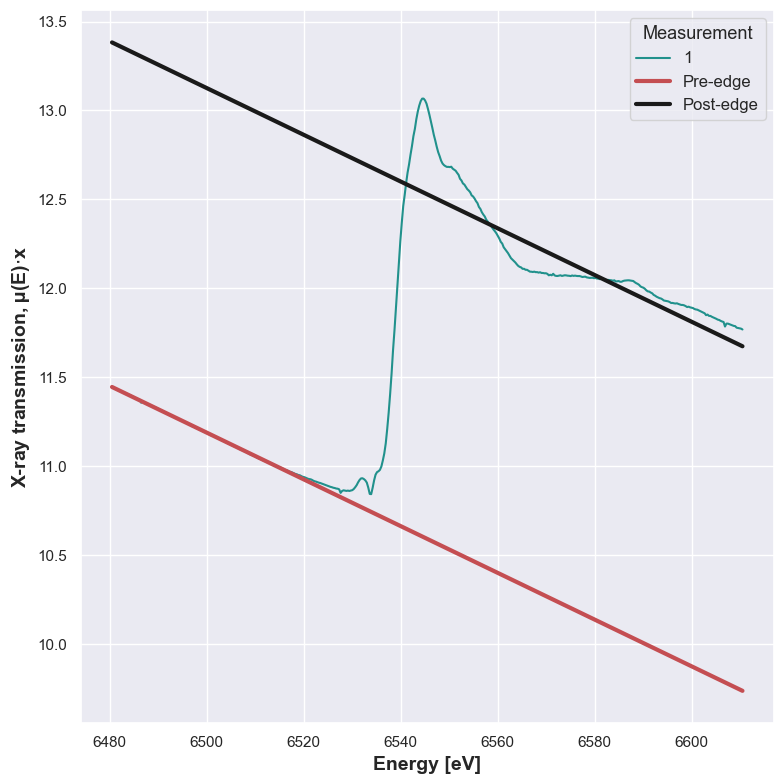

In [8]:
plot_non_normalized_xas(
    df_foils, 
    experiment='Mn', 
    pre_edge=True, 
    post_edge=True, 
    transmission=use_transmission, 
    interactive=interactive_plots
)

### References for precursors/inital state

In [9]:
# Specify the measurements to use when averaging. 
# This can be given as either a list or a range.
measurements_to_average = range(9, 16)

# Create dataframe with the reference spectra for unreduced precursors
df_precursors = average_measurements(df_data, measurements_to_average)

#### Normalization

In [10]:
# Normalization of the data
normalize_data(
    df_precursors, 
    edge_correction_energies, 
    subtract_preedge=use_preedge, 
    transmission=use_transmission
)
df_precursors.head()

,Filename,Experiment,Measurement,albaem01_ch1,albaem01_ch2,albaem02_ch3,albaem02_ch4,Metal,Precursor,Relative_Time,Energy,Temperature,Absorption,Transmission,Energy_Corrected,Normalized,pre_edge,post_edge
3472,21_SO4_S2O8_180-Pt1_1-XANES_09.dat,MnAvg,1,0.000003,0.000003,2.105904e-07,2.645529e-07,Mn,Avg,0.020,6489.000000,0.0,0.0,11.514044,6480.455078,0.001816,0.587619,2.861616
3473,21_SO4_S2O8_180-Pt1_1-XANES_09.dat,MnAvg,1,0.000003,0.000003,2.085554e-07,2.631673e-07,Mn,Avg,0.023,6489.300293,0.0,0.0,11.508955,6480.755371,0.001328,0.583640,2.857637
3474,21_SO4_S2O8_180-Pt1_1-XANES_09.dat,MnAvg,1,0.000003,0.000003,2.094687e-07,2.639595e-07,Mn,Avg,0.026,6489.600586,0.0,0.0,11.505599,6481.055664,0.001602,0.579660,2.853658
3475,21_SO4_S2O8_180-Pt1_1-XANES_09.dat,MnAvg,1,0.000003,0.000003,2.095575e-07,2.649034e-07,Mn,Avg,0.029,6489.900879,0.0,0.0,11.499053,6481.355957,0.000473,0.575681,2.849679
3476,21_SO4_S2O8_180-Pt1_1-XANES_09.dat,MnAvg,1,0.000003,0.000003,2.078264e-07,2.615791e-07,Mn,Avg,0.032,6490.200684,0.0,0.0,11.497055,6481.655762,0.001341,0.571709,2.845706


#### Plotting
It is always a good idea to visually inspect the data to see if it behaves as it should.

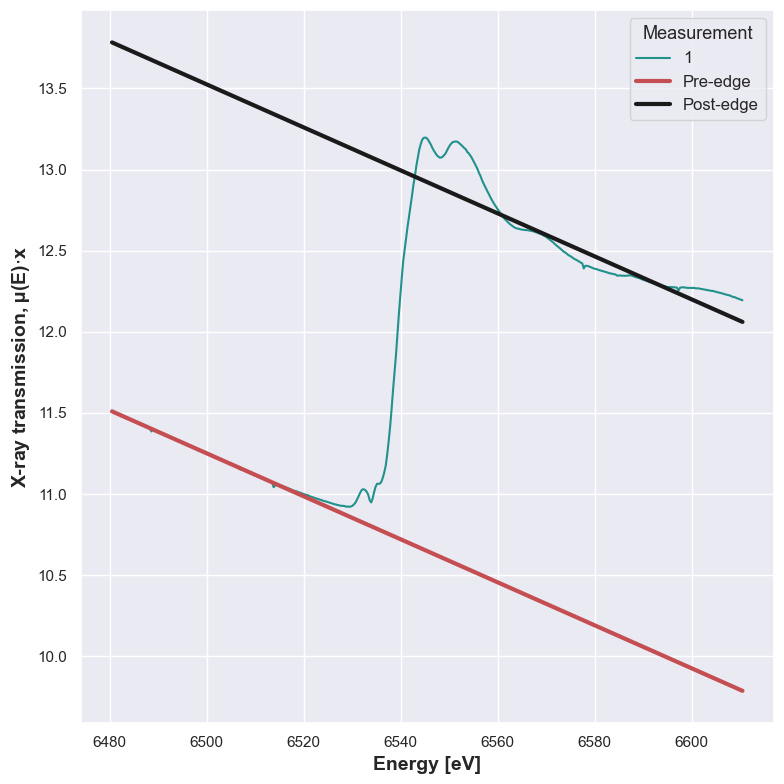

In [11]:
plot_non_normalized_xas(
    df_precursors, 
    experiment='MnAvg', 
    pre_edge=True, 
    post_edge=True, 
    transmission=use_transmission, 
    interactive=interactive_plots
)

## Normalizing data

### Normalization

In [12]:
# Normalization of the data
normalize_data(
    df_data, 
    edge_correction_energies, 
    subtract_preedge=use_preedge, 
    transmission=use_transmission
)
df_data.head()

,Filename,Experiment,Measurement,albaem01_ch1,albaem01_ch2,albaem02_ch3,albaem02_ch4,Metal,Precursor,Relative_Time,Energy,Temperature,Absorption,Transmission,Energy_Corrected,Normalized,pre_edge,post_edge
0,21_SO4_S2O8_180-Pt1_1-XANES_01.dat,Mn,1,0.000003,0.000003,2.016486e-07,2.488454e-07,Mn,None,0.020,6489.000000,0,0,12.146424,6480.455078,0.000246,0.650000,2.814951
1,21_SO4_S2O8_180-Pt1_1-XANES_01.dat,Mn,1,0.000003,0.000003,2.008041e-07,2.486676e-07,Mn,None,0.023,6489.300293,0,0,12.142968,6480.755371,0.000539,0.645908,2.810859
2,21_SO4_S2O8_180-Pt1_1-XANES_01.dat,Mn,1,0.000003,0.000003,2.002463e-07,2.490303e-07,Mn,None,0.026,6489.600586,0,0,12.137151,6481.055664,-0.000258,0.641816,2.806767
3,21_SO4_S2O8_180-Pt1_1-XANES_01.dat,Mn,1,0.000003,0.000003,2.006100e-07,2.485667e-07,Mn,None,0.029,6489.900879,0,0,12.135991,6481.355957,0.001096,0.637725,2.802676
4,21_SO4_S2O8_180-Pt1_1-XANES_01.dat,Mn,1,0.000003,0.000003,1.998650e-07,2.450890e-07,Mn,None,0.032,6490.200684,0,0,12.132730,6481.655762,0.001477,0.633640,2.798591


#### Saving results as .csv file

In [13]:
# save_data(df_data, filename='Normalized_XAS_data.csv')

## Data inspection
It is always a good idea to visually inspect the data to see if it behaves as it should.

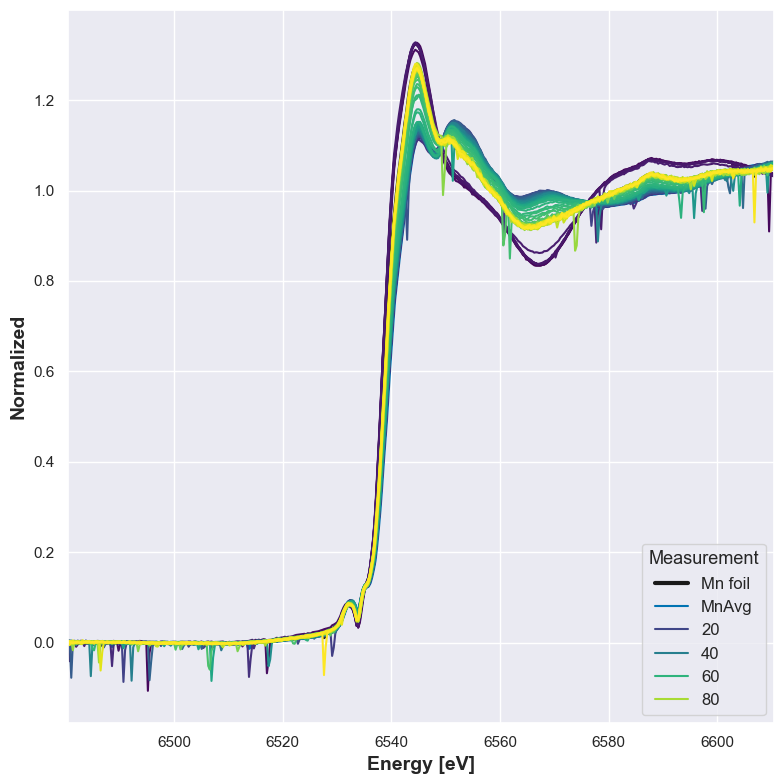

In [14]:
plot_data(
    df_data, 
    metal='Mn', 
    foils=df_foils, 
    precursors=df_precursors, 
    precursor_suffix=None, 
    interactive=interactive_plots
)

## Linear combination analysis
This section performs linear combination analysis (LCA) of every combination of two-component systems consisting of 1 metal foil and 1 precursor (with the same metal). 

The estimated uncertainties of the dependent parameter behaves weird when the independent parameter is approximately zero. In the column "StdCorrected" this is handled by using the same uncertainty for both parameters.

In [15]:
df_results = linear_combination_analysis(df_data, df_foils, df_precursors)
df_results.head()

LCA progress: 100%|██████████| 1/1 [00:01<00:00,  1.97s/it, Analysing Mn + MnAvg]


,Experiment,Metal,Precursor,Precursor Type,Measurement,Temperature,Temperature Average,Temperature Std,Parameter,Value,StdErr,StdCorrected,Basis Function
0,Mn + MnAvg,Mn,MnAvg,Avg,1,0.0,0,NaN,foil_weight,1.0,5.746731e-07,5.746731e-07,"[0.0005299618264976697, -0.0003488729509991208..."
1,Mn + MnAvg,Mn,MnAvg,Avg,1,0.0,0,NaN,precursor_weight,0.0,5.746731e-07,5.746731e-07,"[0.0018160658710486071, 0.0013280271813192962,..."
2,Mn + MnAvg,Mn,MnAvg,Avg,2,0.0,0,NaN,foil_weight,1.0,1.130774e-06,1.130774e-06,"[0.0005299618264976697, -0.0003488729509991208..."
3,Mn + MnAvg,Mn,MnAvg,Avg,2,0.0,0,NaN,precursor_weight,0.0,1.130774e-06,1.130774e-06,"[0.0018160658710486071, 0.0013280271813192962,..."
4,Mn + MnAvg,Mn,MnAvg,Avg,3,0.0,0,NaN,foil_weight,1.0,4.735692e-03,4.735692e-03,"[0.0005299618264976697, -0.0003488729509991208..."


#### Saving results as .csv file

In [16]:
# save_data(df_results, filename='LCA_results.csv')

### Results plotting

#### Temperature curves

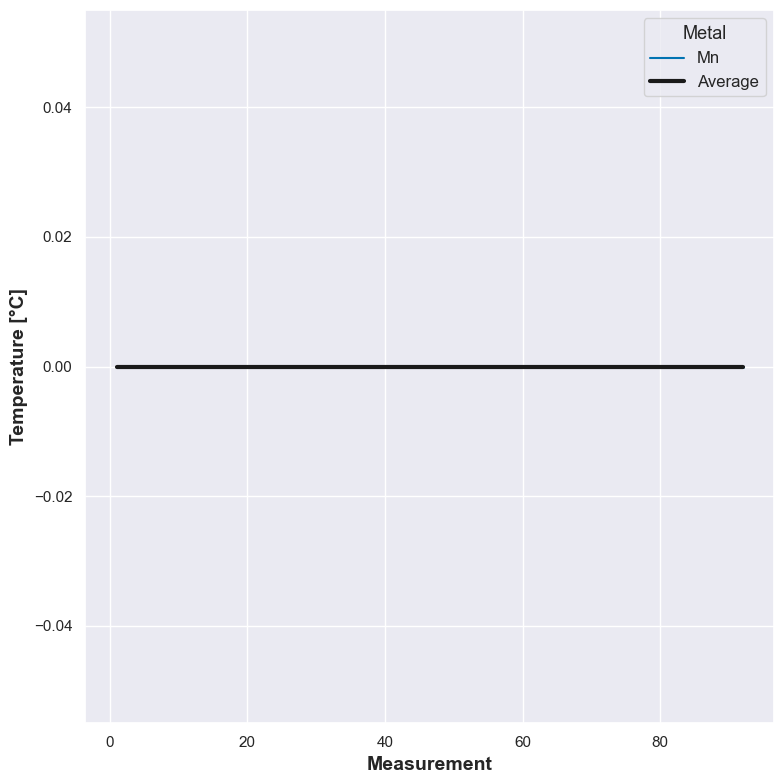

In [17]:
plot_temperatures(
    df_results, 
    with_uncertainty=True, 
    interactive=interactive_plots
)

#### Plot of a single LCA fit
Plot showing the measurement that is being fitted, the contributions from the components and the residual.

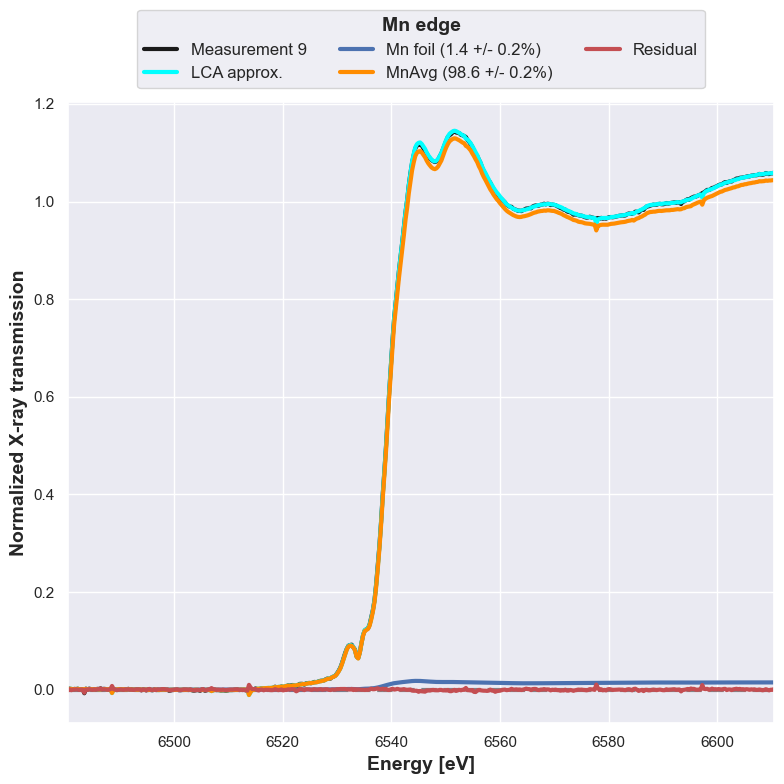

In [18]:
plot_LCA(
    df_results, 
    df_data, 
    experiment='Mn + MnAvg', 
    measurement=9, 
    interactive=interactive_plots
)

#### Plot of LCA component weights over time
Plot showing how the weight of each component changes over time.

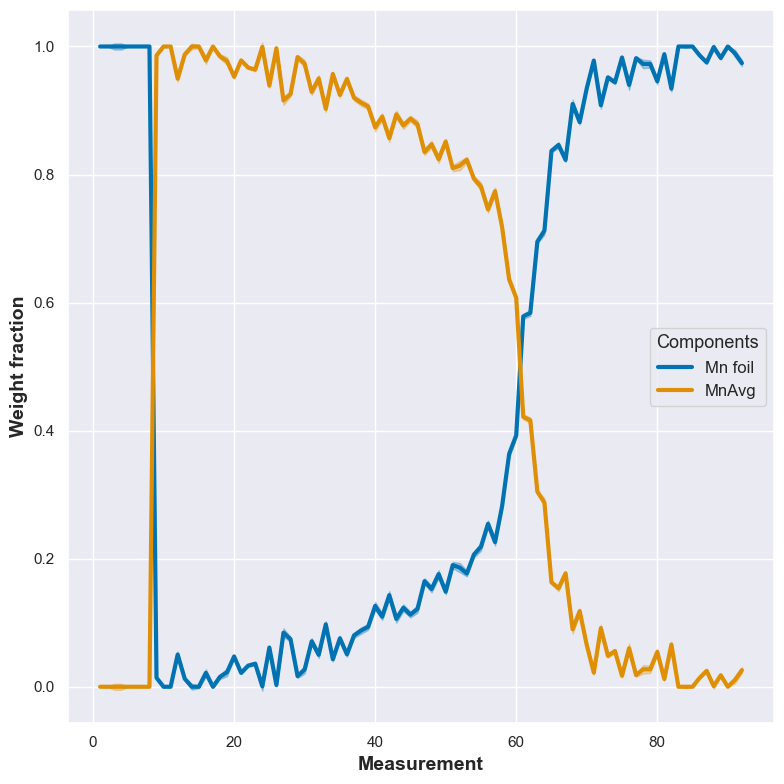

In [19]:
plot_LCA_change(
    df_results, 
    metal='Mn', 
    precursor_suffix='Avg', 
    x_axis='Measurement', 
    with_uncertainty=True, 
    interactive=interactive_plots
)

#### Comparison of reduction times of different metals
Plot showing the weight of the metal foil component over time for the different metal species in the sample. 

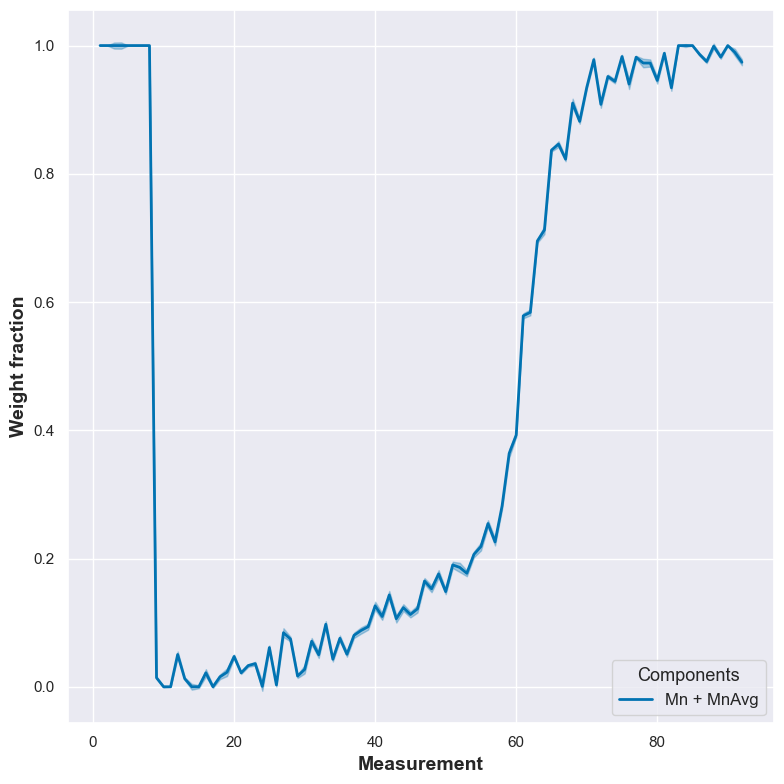

In [20]:
plot_reduction_comparison(
    df_results, 
    precursor_type='all', 
    x_axis='Measurement', 
    with_uncertainty=True, 
    interactive=interactive_plots
)